# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties, FlowPropertiesMarder, FlowPropertiesTwoPhase, 
    SinglePhaseReservoir, SinglePhaseReservoirMarder,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure,BuildPVT
from bluebonnet.fluids import HallYarbEOS
from bluebonnet import plotting
pd.set_option('display.max_rows', 100)
import pickle as pkl
Results={}

#import sys
#sys.path.insert(0,"/Users/michaelmarder/UTOneDrive/OneDrive - The University of Texas at Austin/Shale/bluebonnet/src/")
#plt.style.use("ggplot")

In [2]:
Results=pkl.load(file=open("Results.pkl","rb"))

In [3]:
from bluebonnet.fluids.gas import z_factor_DAK
Pressure=np.arange(0.0,14000.0,10.0)
Pressure[0]=.001
Pc=6000
Tc=-100
%time Z=np.array( [z_factor_DAK(150,p,Tc,Pc)for p in Pressure])



CPU times: user 7.4 s, sys: 101 ms, total: 7.5 s
Wall time: 7.42 s


In [4]:
ZZ= lambda p: z_factor_DAK(150,p,Tc,Pc)
vZZ=np.vectorize(ZZ)
%time vZZ(Pressure)

CPU times: user 7.3 s, sys: 60.4 ms, total: 7.36 s
Wall time: 7.32 s


array([1.        , 0.99992464, 0.99983549, ..., 0.92164042, 0.92161962,
       0.92159887])

In [5]:
Pressure

array([1.000e-03, 1.000e+01, 2.000e+01, ..., 1.397e+04, 1.398e+04,
       1.399e+04])

In [6]:
def plot_pseudopressure(reservoir, rescale=False,ax=None,xmax=1,mbot=0,mtop=1.05):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(1/reservoir.nx, 1, reservoir.nx)
    pinit=reservoir.pseudopressure[0,-1]
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            if rescale:
                pscale=(p-p[0])/(pinit-p[0])
                ax.plot(x,pscale, color='steelblue')
            else:
                ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, xmax), ylim=(mbot,mtop))
    return fig, ax

def plot_recovery_rate(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    rate=reservoir.rate
    time = reservoir.time
    ax.plot(time, rate)
    ax.set(xscale='log', yscale='log',ylim=(1.e-4, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


In [7]:
t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2


## Real gas simulation

In [96]:
Pi=12000
Pf=1000
Pf=5000

n_times=1000


t_end = 20
time = np.linspace(0, np.sqrt(t_end), n_times) ** 2
PressureTime=np.ones(n_times)
for i in range(n_times):
    if i<n_times/4: 
        PressureTime[i]=Pf 
    elif i<n_times/2:
        PressureTime[i]=Pf/2 
    else: 
        PressureTime[i]=Pf/4


pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)


flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
density_interp = interpolate.interp1d(flow_propertiesM.df["m_scaled"], flow_propertiesM.df["Density"])

print('mf=',flow_propertiesM.m_scaled_func(Pf))

res_realgasM = SinglePhaseReservoirMarder(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime=PressureTime)

rf2M = res_realgasM.recovery_factor()
rf2M[-1]


mf= 0.09660769499003893
CPU times: user 3.12 s, sys: 28.4 ms, total: 3.15 s
Wall time: 3.17 s


0.8276580948155892

In [42]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
pvt_gas

,T,P,Z-Factor,Bg,Density,Cg,Viscosity,pseudopressure
0,400,0,0.999577,0.294490,0.030003,0.068074,0.016332,0.000000e+00
1,400,10,0.999291,0.175194,0.050433,0.040521,0.016333,2.413310e+04
2,400,20,0.999006,0.124664,0.070874,0.028850,0.016333,6.052784e+04
3,400,30,0.998724,0.096745,0.091327,0.022402,0.016334,1.091900e+05
4,400,40,0.998443,0.079035,0.111791,0.018311,0.016335,1.701252e+05
...,...,...,...,...,...,...,...,...
1196,400,11960,1.502527,0.000543,16.263662,0.000040,0.029418,4.900670e+09
1197,400,11970,1.503177,0.000543,16.270207,0.000040,0.029430,4.906088e+09
1198,400,11980,1.503827,0.000543,16.276745,0.000040,0.029441,4.911506e+09
1199,400,11990,1.504476,0.000543,16.283278,0.000040,0.029452,4.916925e+09


0.3631517889980861
0.09660769499003893 0.007089359639632412 Devation is -0.79%


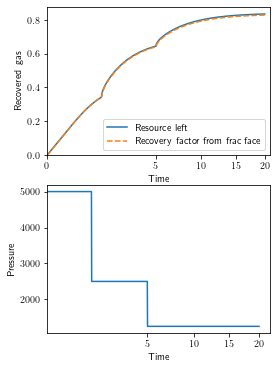

In [98]:
from scipy import interpolate
density_interp = interpolate.interp1d(flow_propertiesM.df["m_scaled"], flow_propertiesM.df["Density"])

def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.df["m_scaled"], pvt.df["Density"])
    print(max(pvt.df["m_scaled"]))
    p=np.minimum(pseudopressure,max(pvt.df["m_scaled"]))
    return (density(p)).sum(axis=1)/len(pseudopressure[0])
mf=flow_propertiesM.m_scaled_func(Pf)
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Devation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(4, 6)
ax1.plot(time, 1 - remaining_gasM, label="Resource left")
ax1.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax1.legend()
ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax2.plot(time, PressureTime , label="Pressure")
ax2.set(xlabel="Time",  xscale='squareroot',ylabel="Pressure")

pp=PdfPages('PressureCheck.pdf')
pp.savefig(fig)
pp.close()

In [110]:
D

,Unnamed: 0,Days,Gas,Oil,Water,Pressure
0,3,1.625000,0.000000,0.00,102.00,6281.546753
1,4,1.666667,0.000000,0.00,103.00,6282.200099
2,5,1.708333,0.000000,0.00,101.00,6275.901095
3,6,1.750000,0.000000,0.00,115.00,6315.124140
4,7,1.791667,0.000000,0.00,126.00,6311.044420
5,8,1.833333,0.000000,1.00,121.00,6272.281351
6,9,1.875000,0.000000,1.00,127.00,6308.592936
7,10,1.916667,0.000000,2.00,121.00,6261.363704
8,11,1.958333,0.000000,2.00,126.00,6292.273897
9,12,2.000000,0.000000,1.00,120.00,6235.301270


# Create Equation of State

In [8]:
WellNumber=12
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
E.loc['Initial Pressure Estimate (psi)'][E.columns[0]]
Play=E.loc['Formation/Reservoir'][E.columns[0]]
E

,LORIKEET
Field,
Lease,LORIKEET
Well Number,62
State,LA
Formation/Reservoir,HAYNESVILLE SHALE
Initial Pressure Estimate (psi),9939
Reservoir Temperature (deg F),285.21375
Net Pay (ft),268.39703
Wellbore Diameter (ft),0.7
Porosity,0.0880000591278076


In [9]:
FieldValues=E.iloc[:,0]
GasDryness='wet gas'
pvt_gas=BuildPVT(FieldValues,GasDryness)
pvt_gas.to_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')

ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas['pseudopressure']=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)

M0=10
MMax=100000

In [19]:
pvt_gas

,T,P,Density,Z-Factor,Cg,Viscosity,pseudopressure
0,285.21375,0.001,0.000002,1.000000,1000.000043,0.014637,0.000000e+00
1,285.21375,10.000,0.021024,0.999592,0.100043,0.014638,6.834483e+03
2,285.21375,20.000,0.042065,0.999181,0.050043,0.014638,2.734322e+04
3,285.21375,30.000,0.063123,0.998775,0.033376,0.014639,6.153650e+04
4,285.21375,40.000,0.084198,0.998370,0.025043,0.014639,1.094242e+05
...,...,...,...,...,...,...,...
1395,285.21375,13950.000,17.710554,1.655297,0.000029,0.029885,6.092854e+09
1396,285.21375,13960.000,17.715675,1.656005,0.000029,0.029895,6.098494e+09
1397,285.21375,13970.000,17.720791,1.656713,0.000029,0.029905,6.104133e+09
1398,285.21375,13980.000,17.725903,1.657421,0.000029,0.029915,6.109772e+09


,T,P,Density,Z-Factor,Cg,Viscosity
1202,115.0,12020.0,19.092256,1.685381,0.000029,0.029151


In [94]:
for WellNumber in range(1,53):
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    WellProperties.loc[WellNumber]["Comments"]=E.iloc[-1][2]
    WellNumber.loc[WellNumber]['DayMin']=0

WellNumber.loc[1]['DayMax']=1100    

In [112]:
    WellNumber=1
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    print(D[(D['Days'] >1100) & (D['Days'] <1150)][['Days','Gas','Pressure']])

      Days    Gas     Pressure
1092  1101  0.000          NaN
1093  1102  0.000          NaN
1094  1103  0.000          NaN
1095  1104  0.000          NaN
1096  1105  0.000          NaN
1097  1106  0.000          NaN
1098  1107  0.000          NaN
1099  1108  0.000          NaN
1100  1109  0.000          NaN
1101  1110  0.000          NaN
1102  1111  0.000          NaN
1103  1112  0.000          NaN
1104  1113  0.000          NaN
1105  1114  0.000          NaN
1106  1115  0.000          NaN
1107  1116  0.000          NaN
1108  1117  0.000          NaN
1109  1118  0.000          NaN
1110  1119  0.000          NaN
1111  1120  0.000          NaN
1112  1121  0.121          NaN
1113  1122  0.028          NaN
1114  1123  0.037          NaN
1115  1124  0.037  4224.094241
1116  1125  0.036  4200.497993
1117  1126  0.036  4018.343444
1118  1127  0.038  4055.775024
1119  1128  0.029  4038.574283
1120  1129  0.028  4082.058668
1121  1130  0.027  3993.667185
1122  1131  0.027  3999.511020
1123  11

/var/folders/mv/xtq5fvh134qc0zf3xwhl7ps80000gn/T/ipykernel_91281/4290381160.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(1,2)


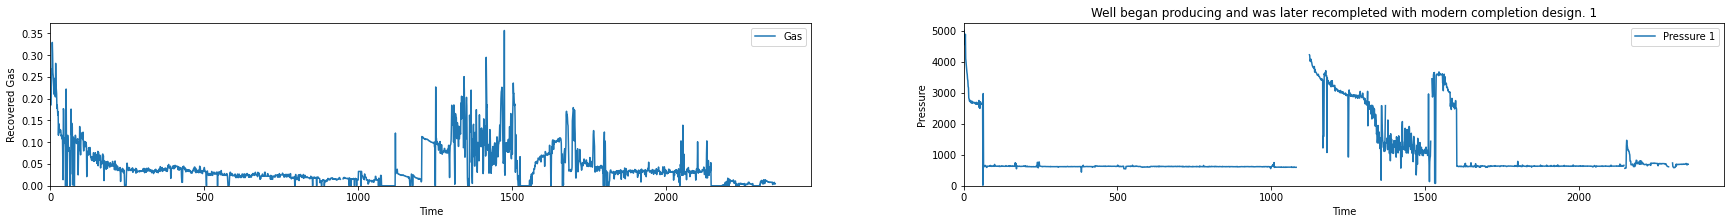

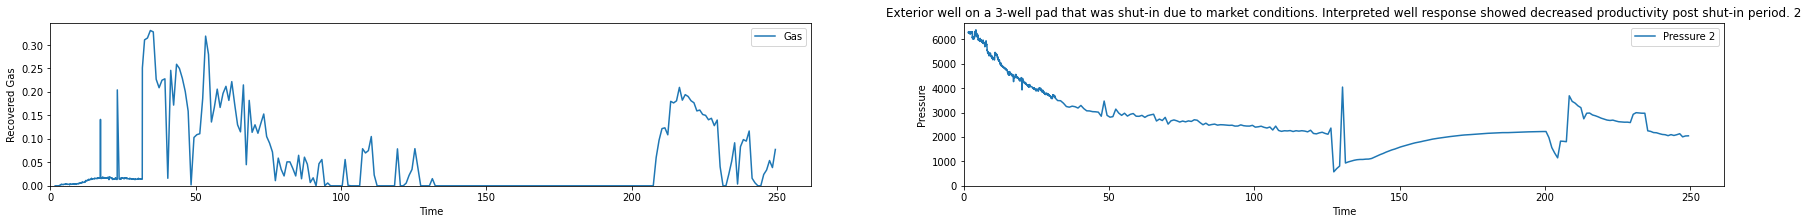

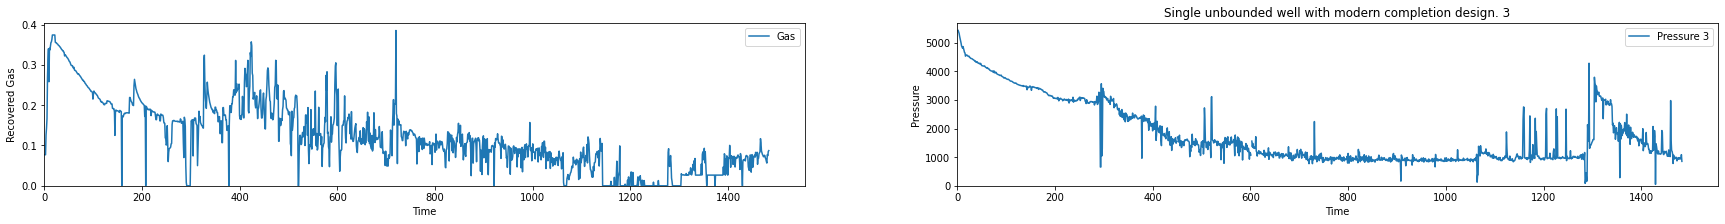

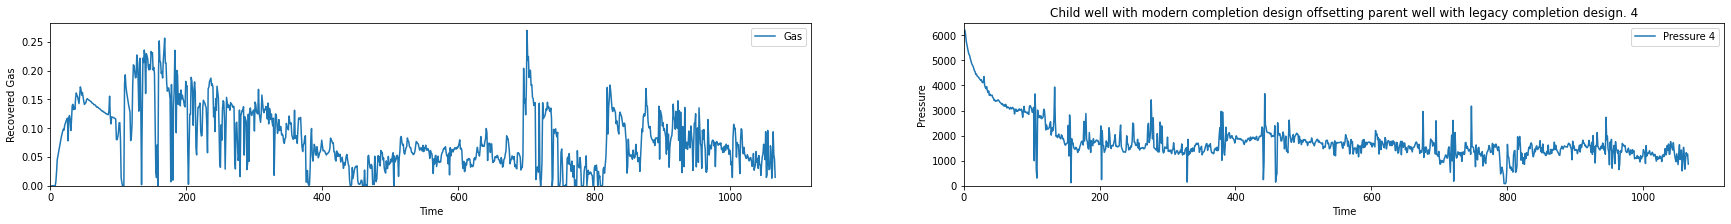

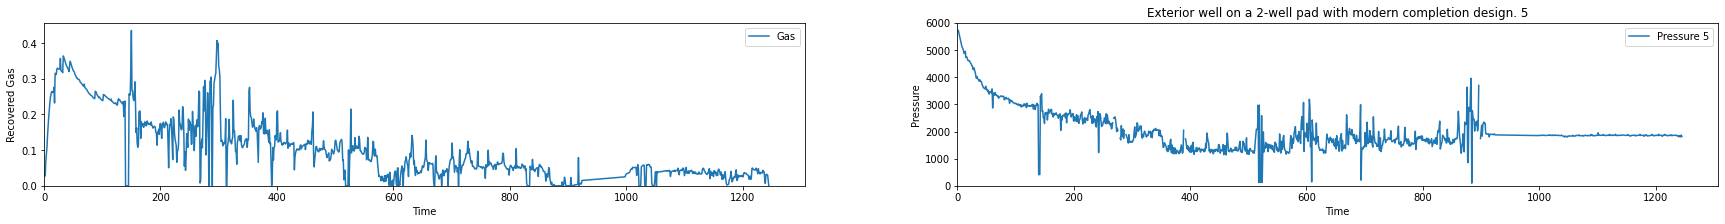

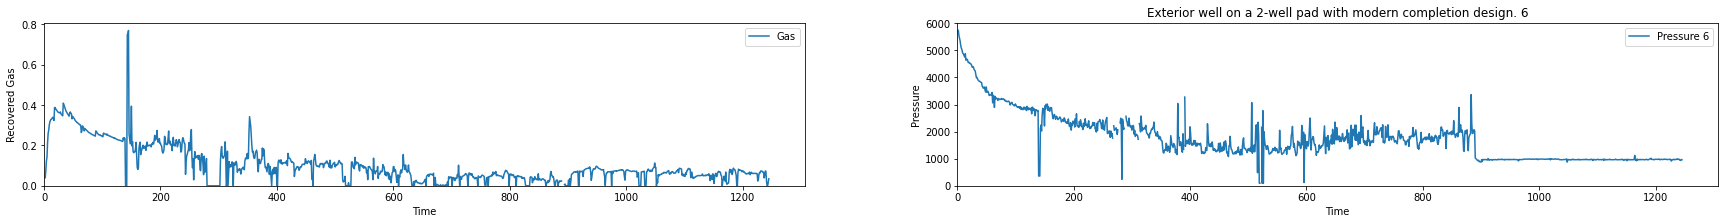

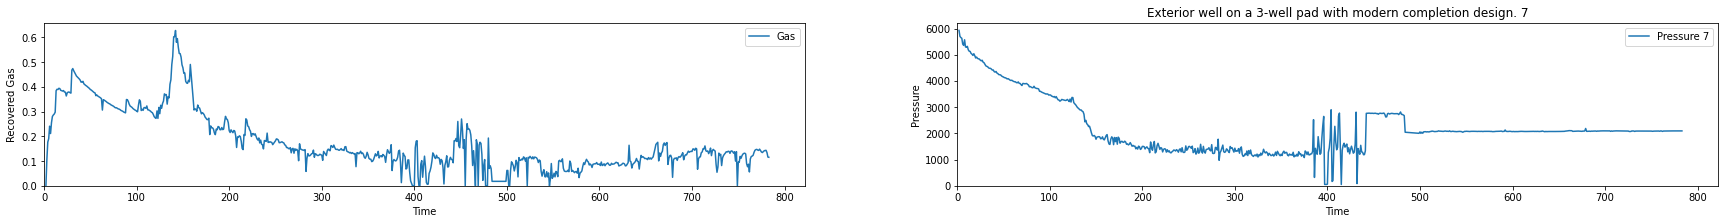

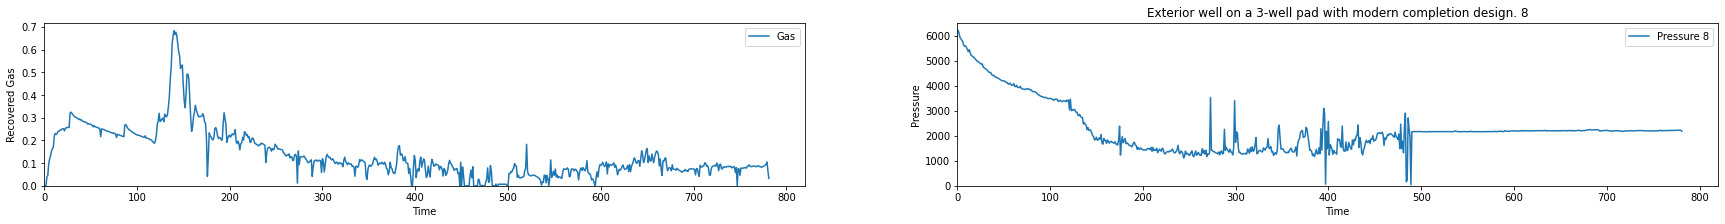

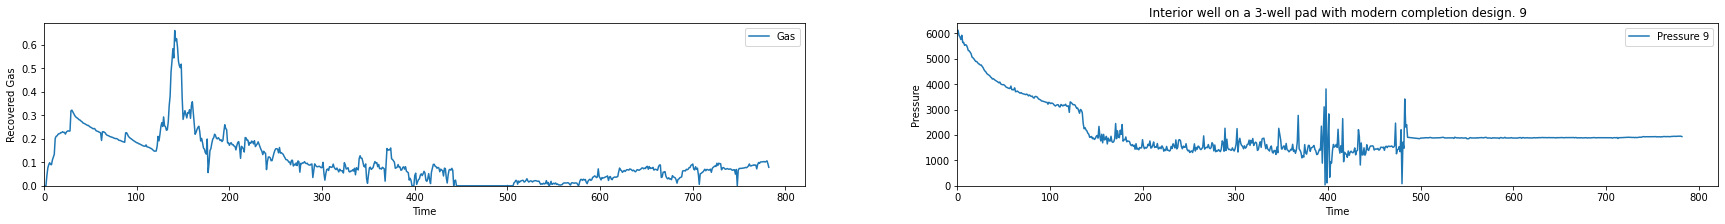

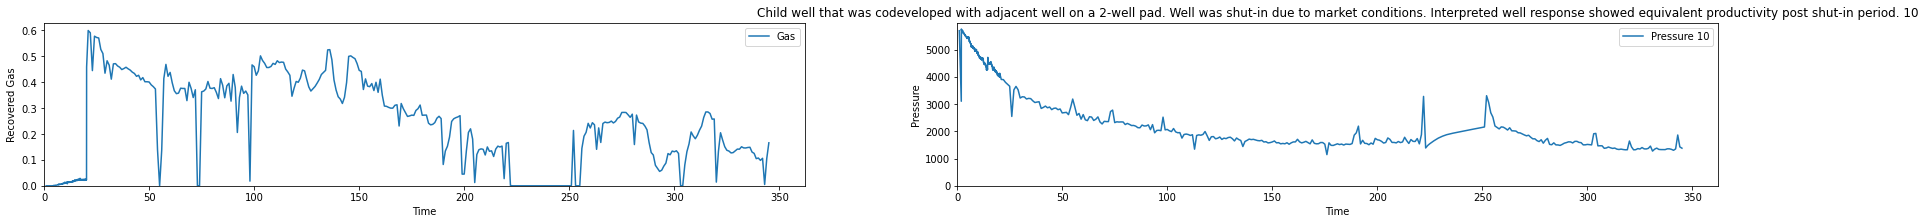

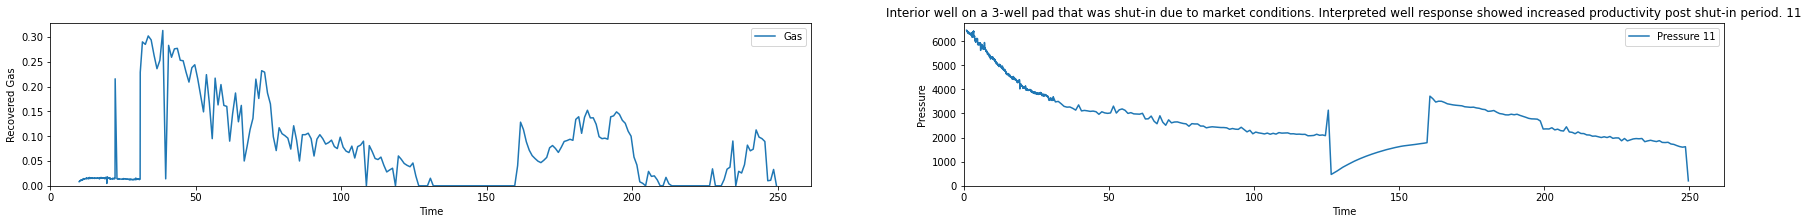

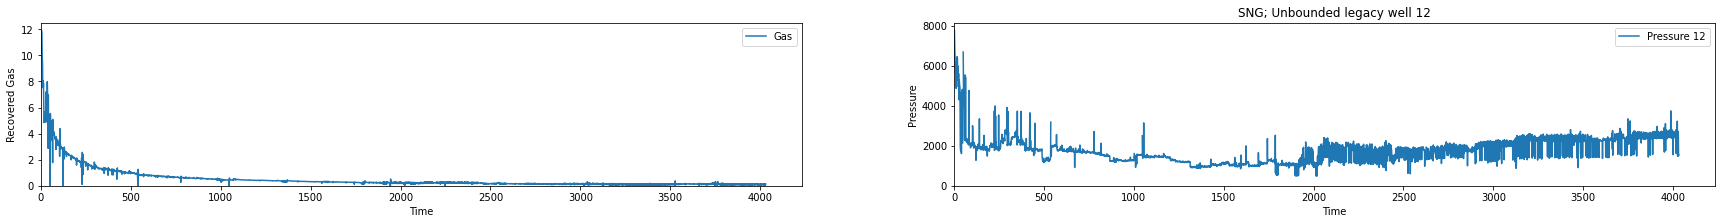

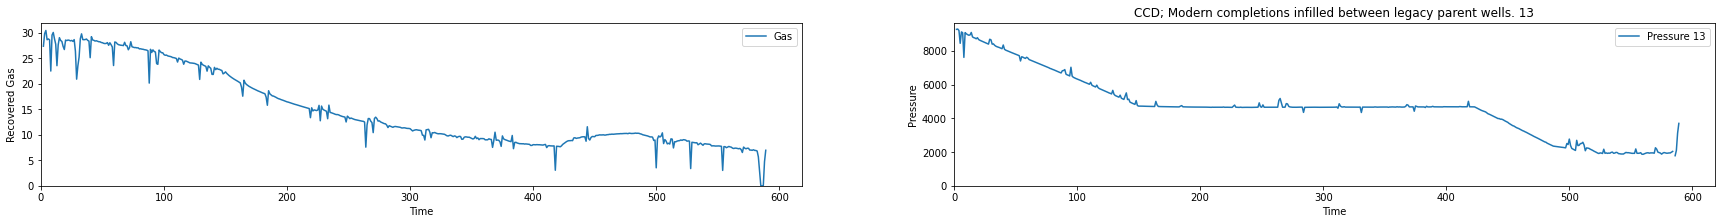

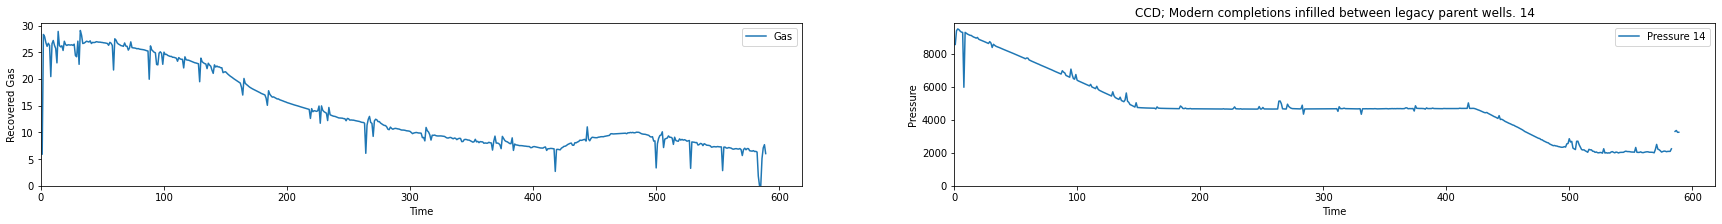

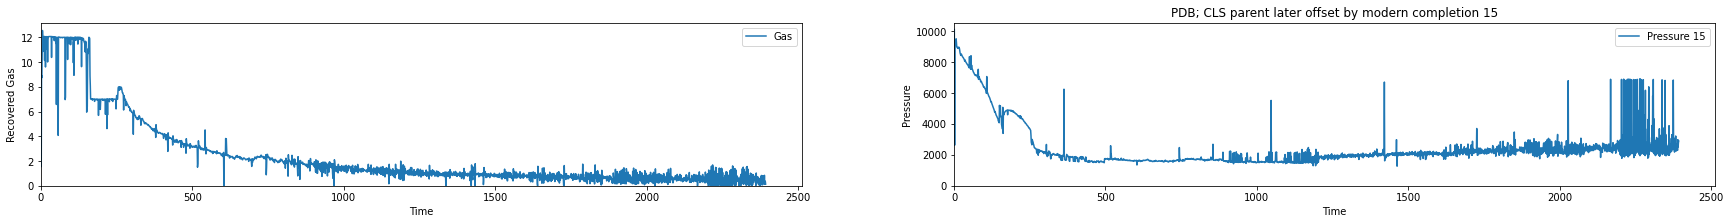

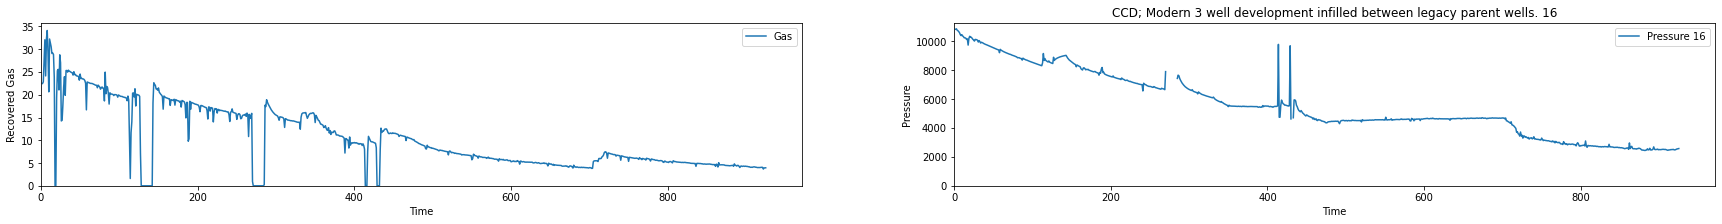

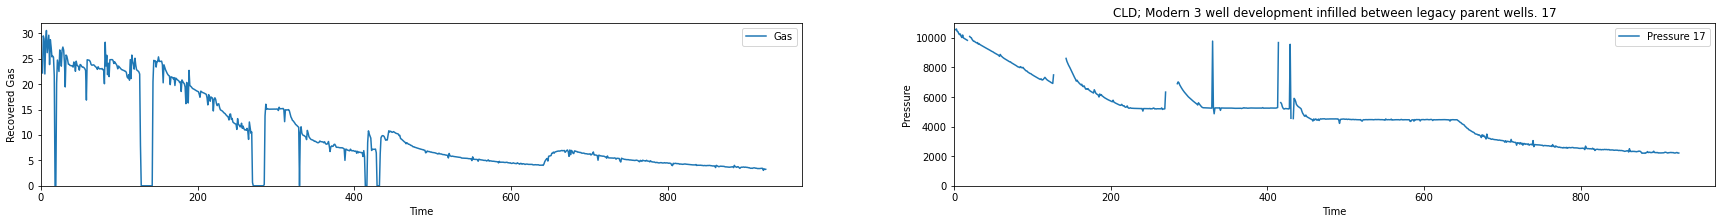

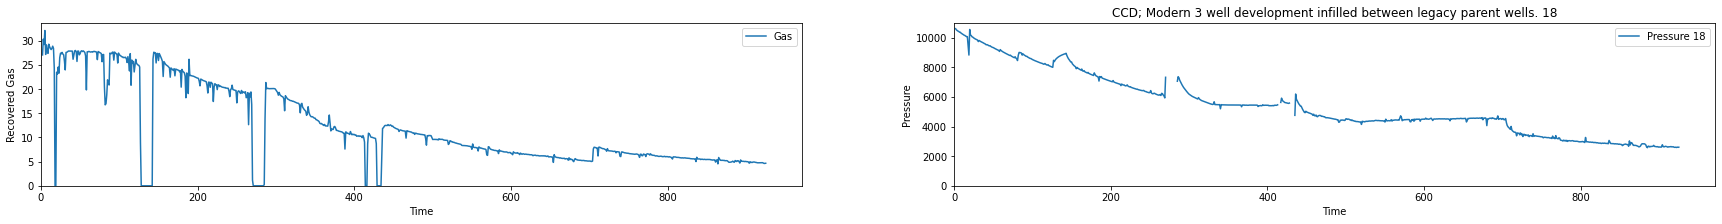

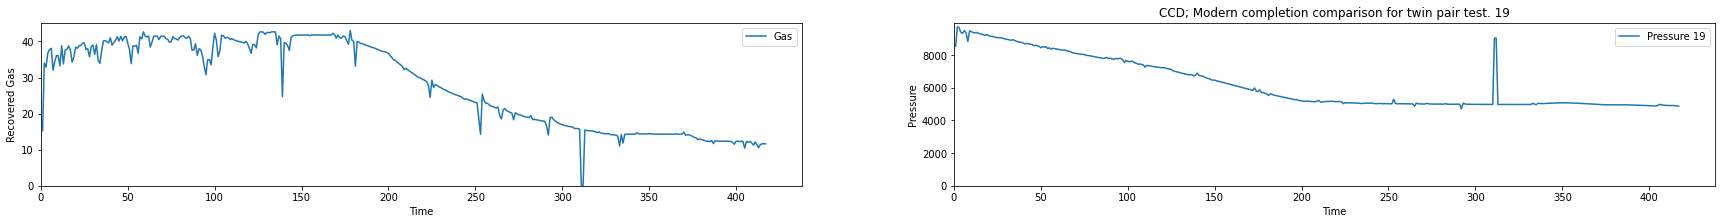

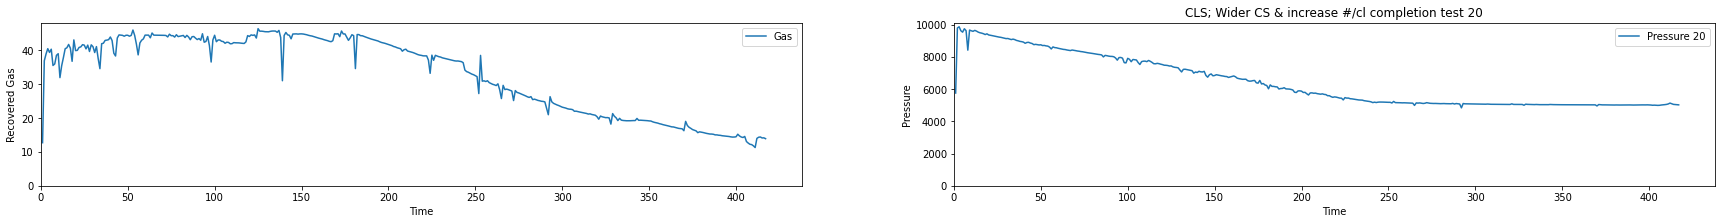

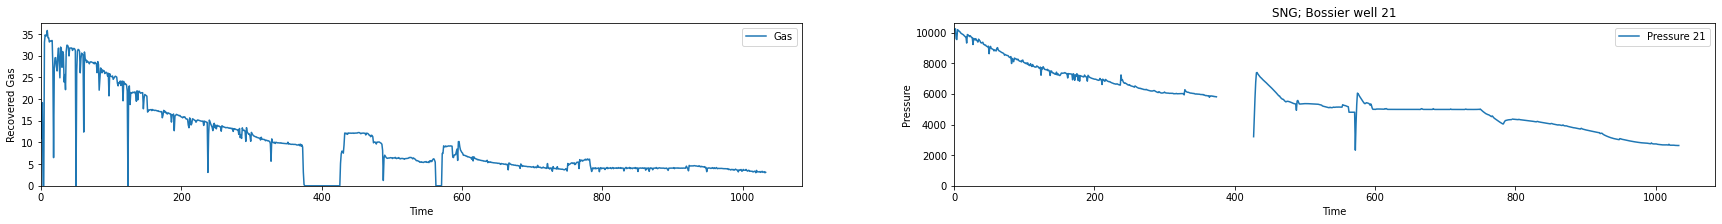

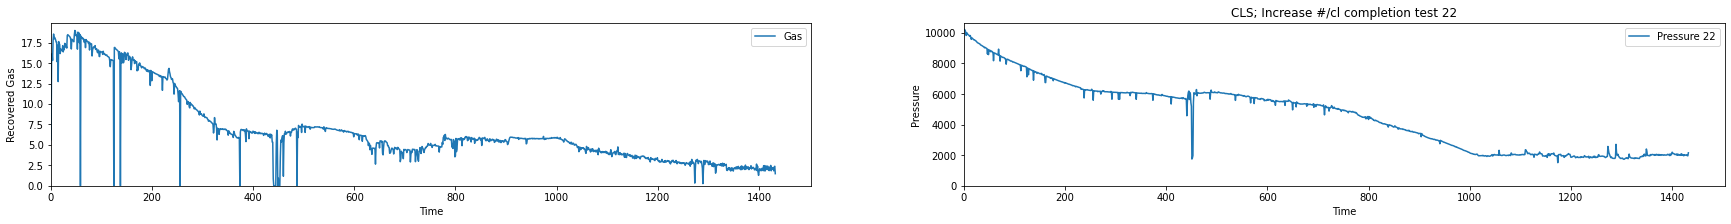

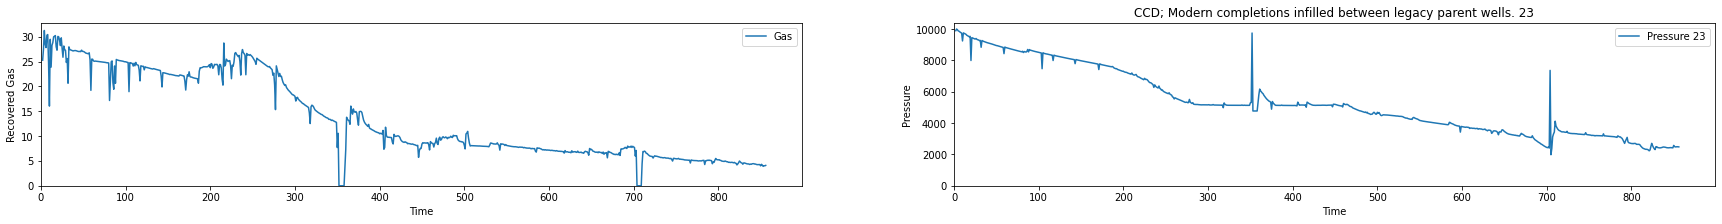

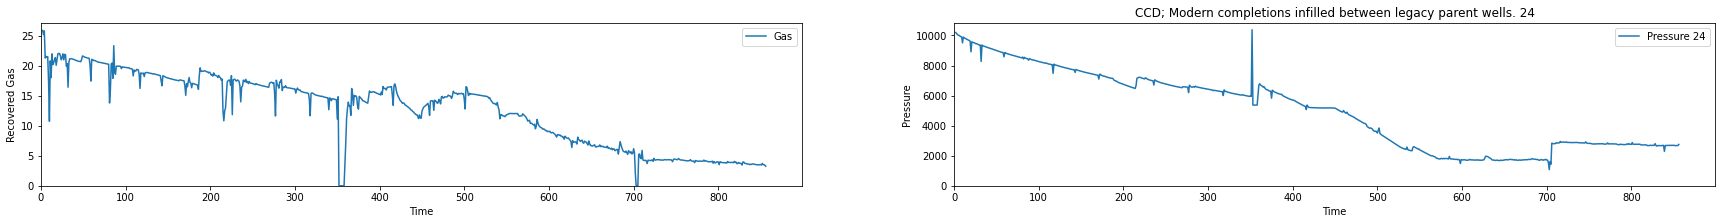

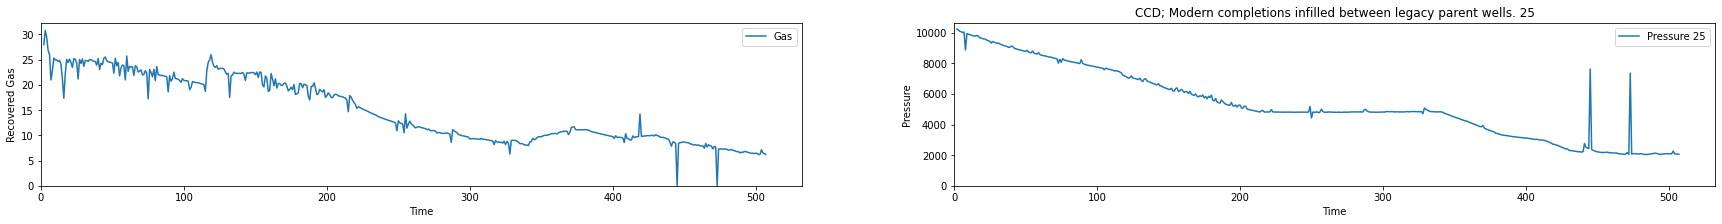

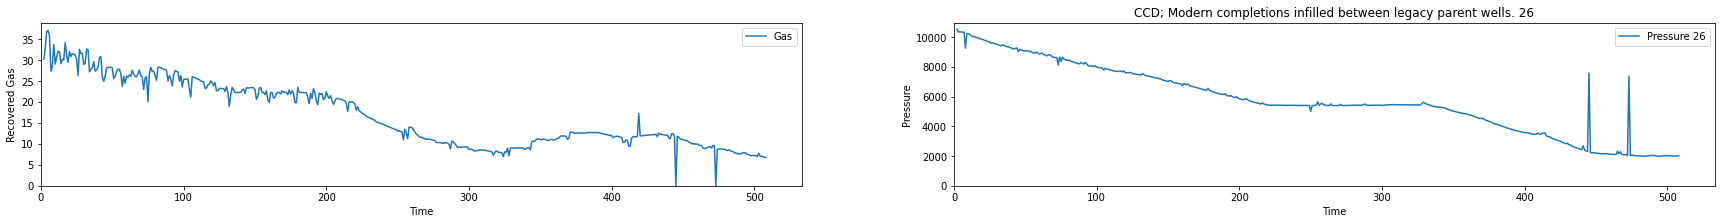

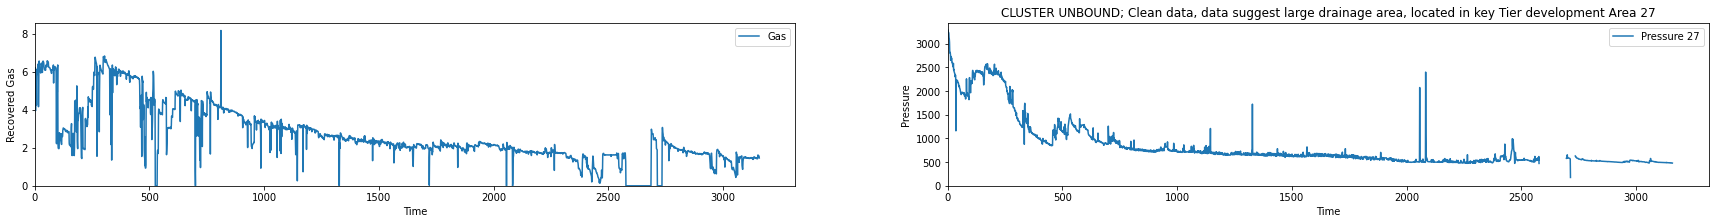

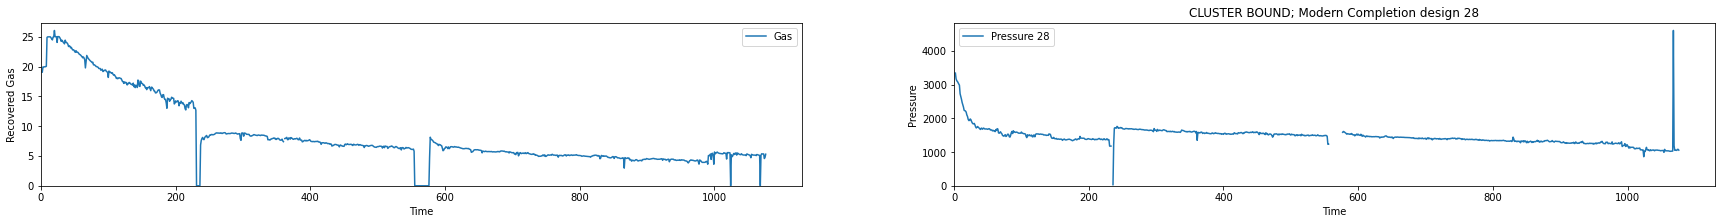

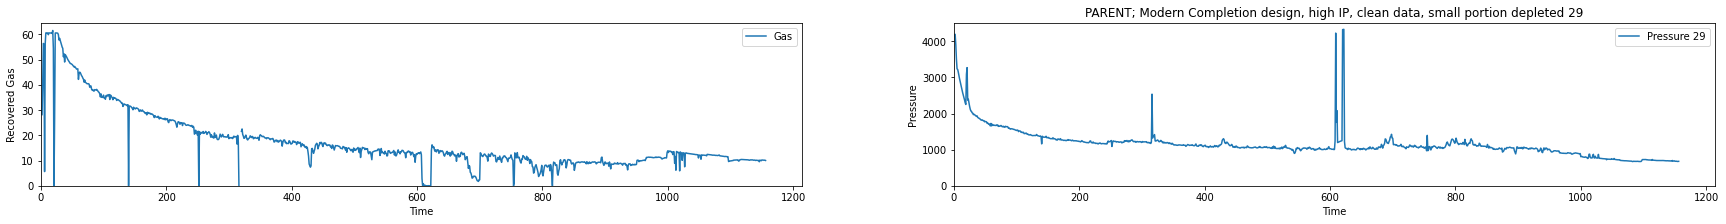

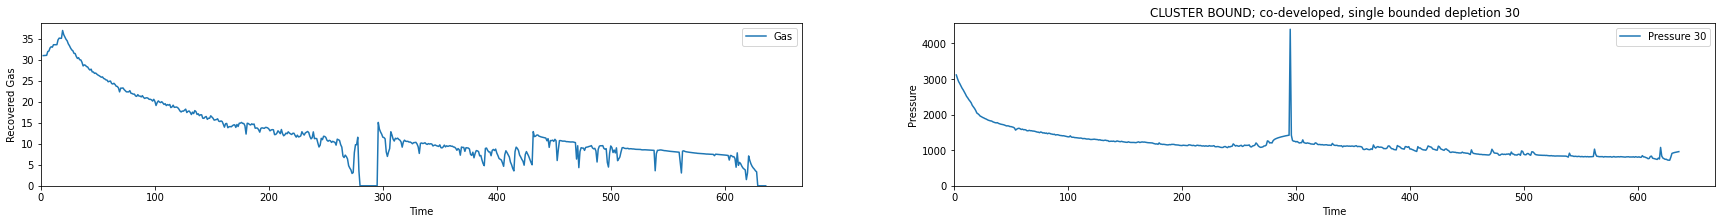

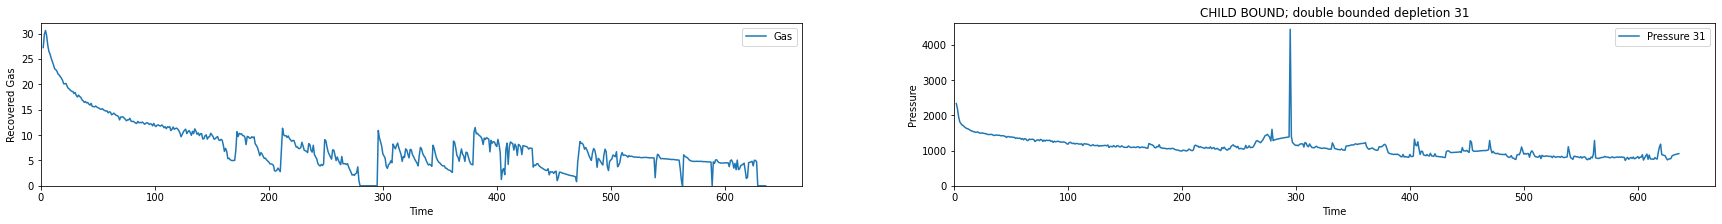

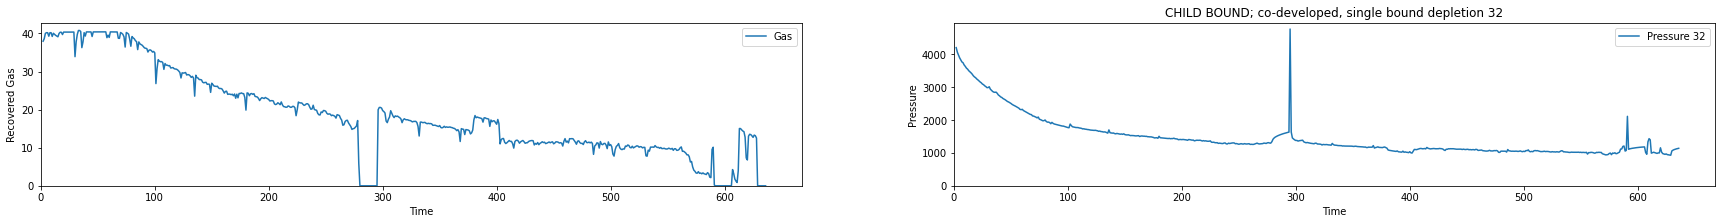

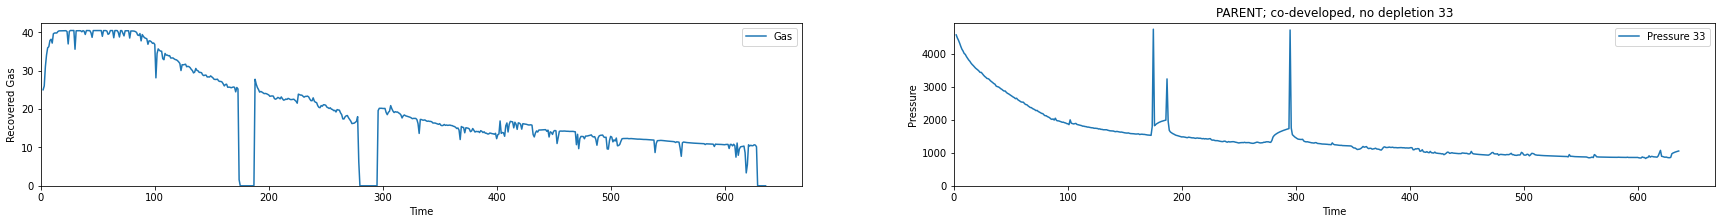

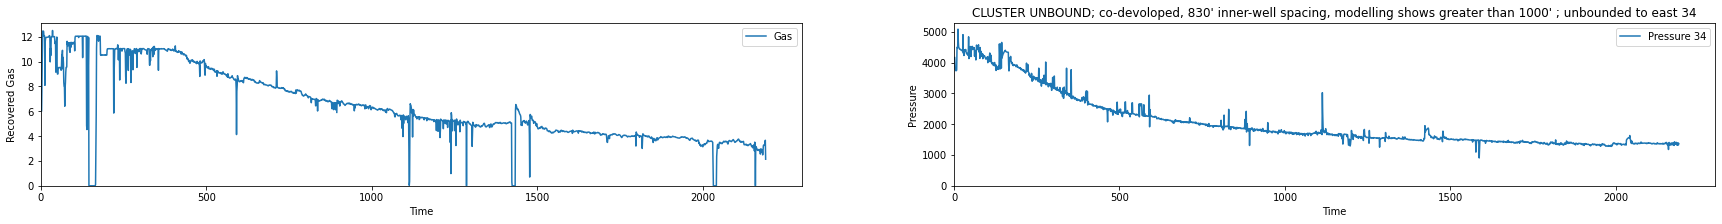

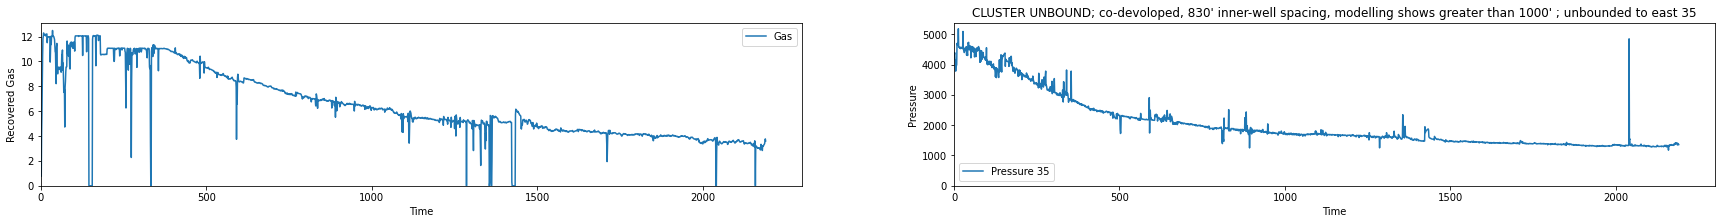

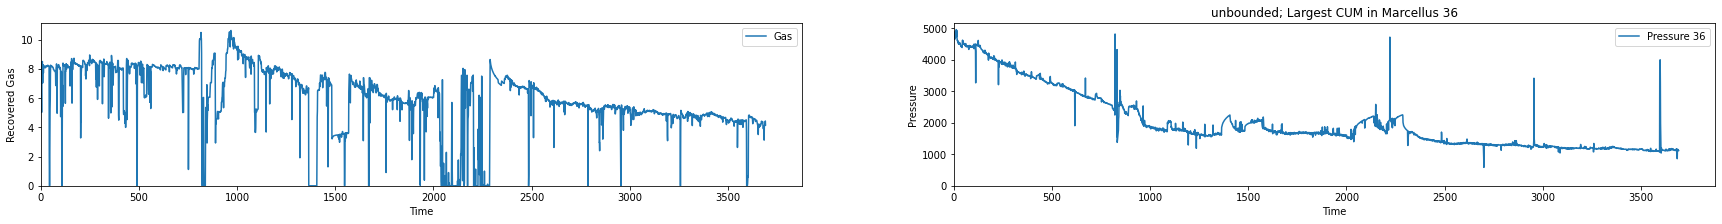

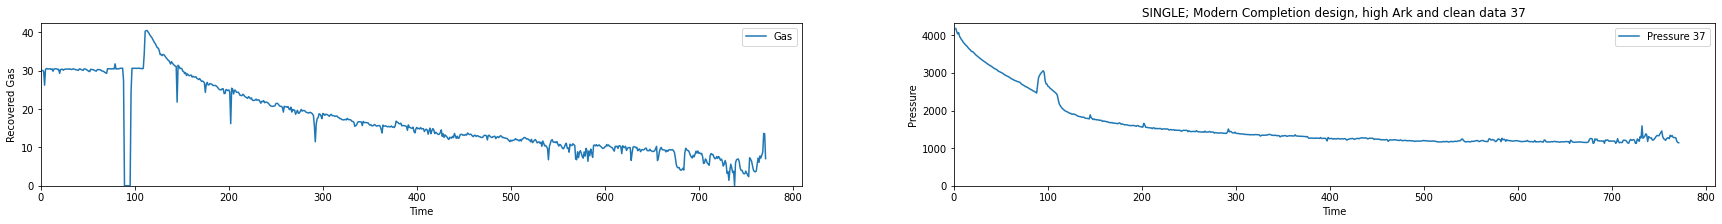

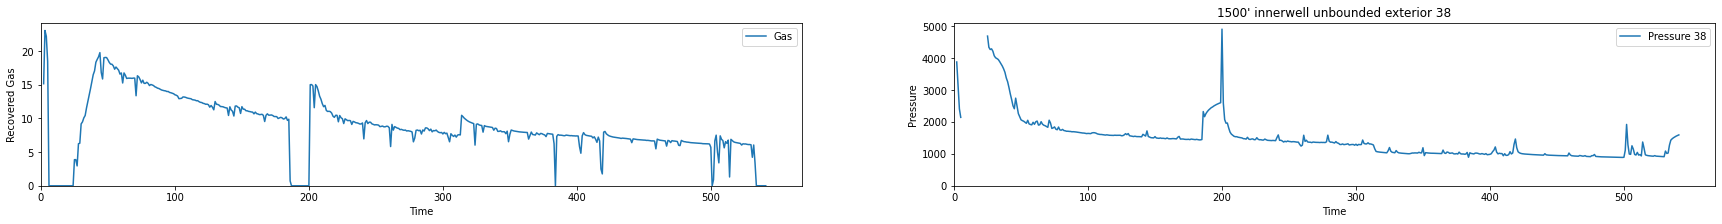

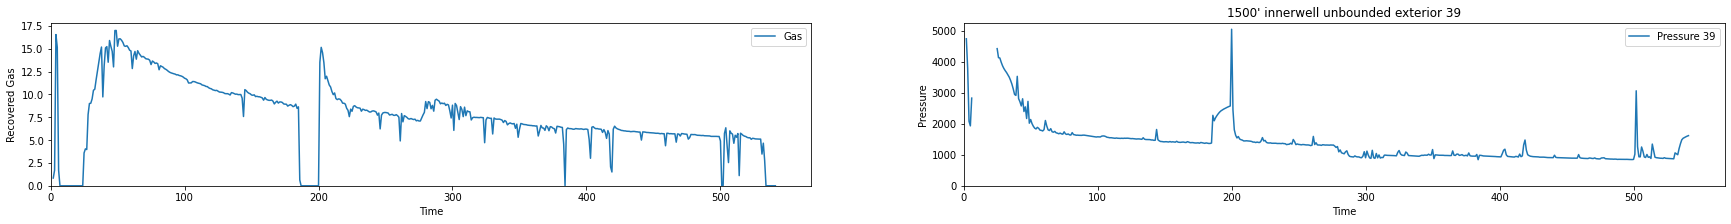

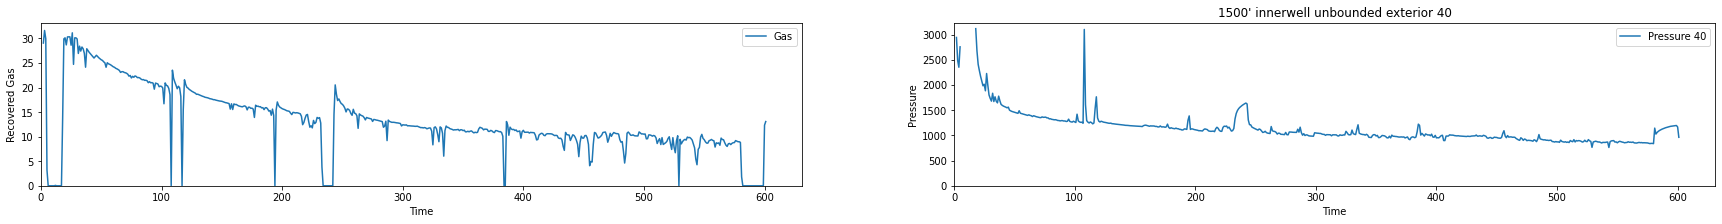

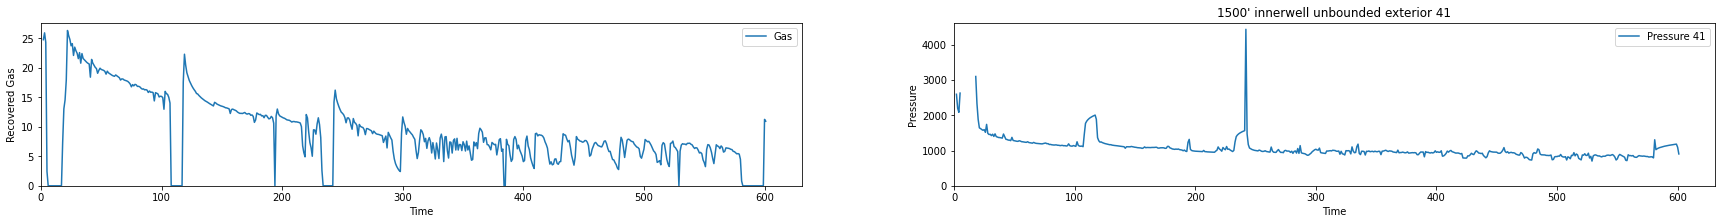

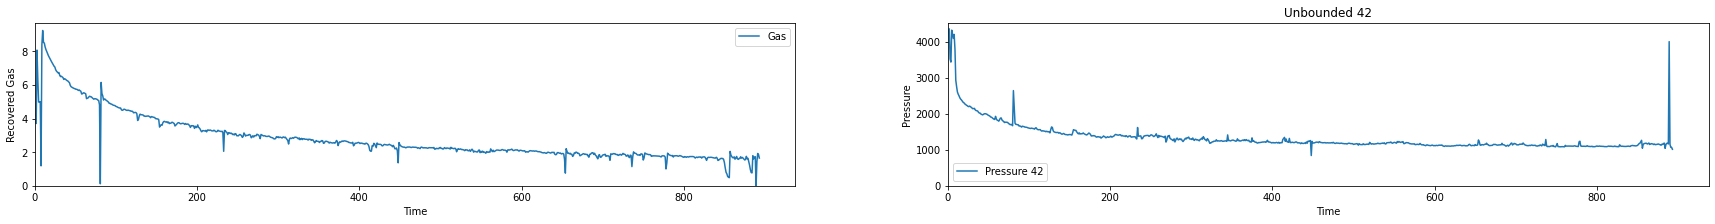

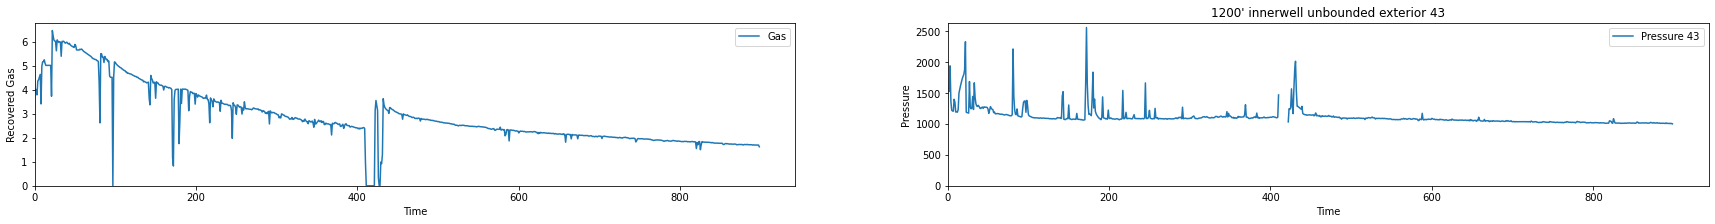

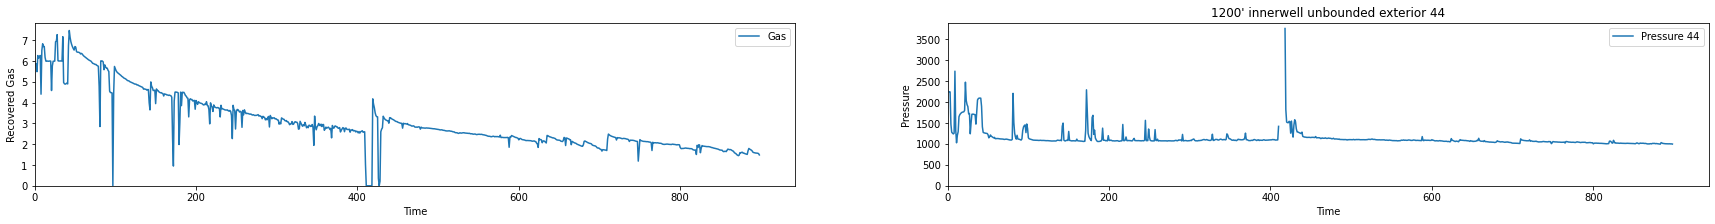

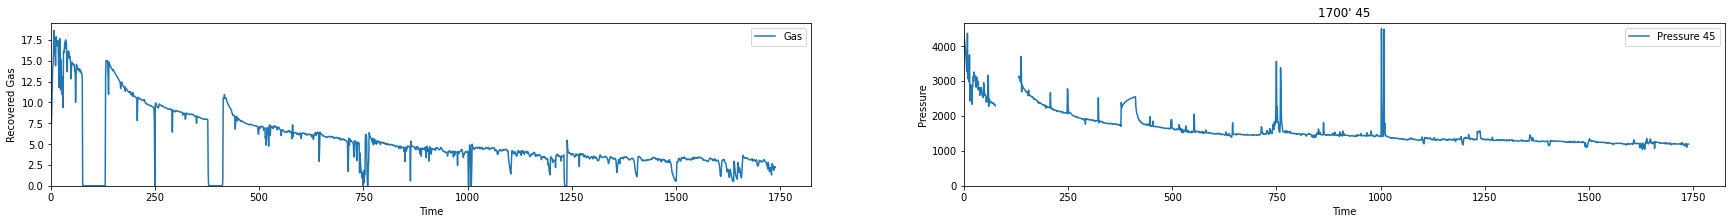

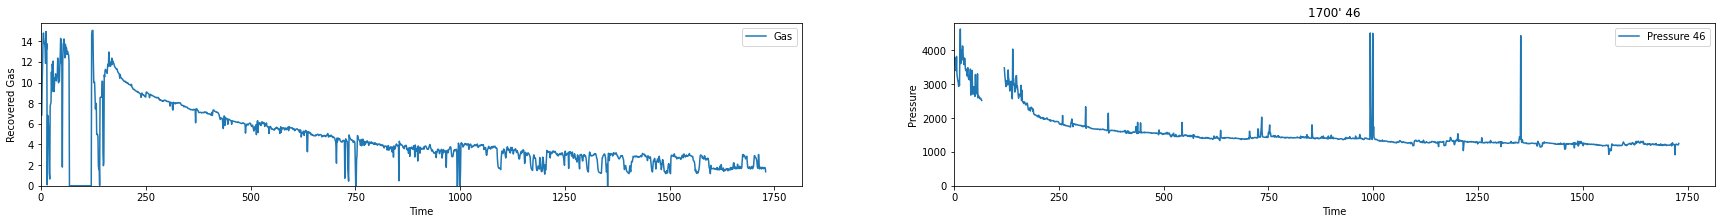

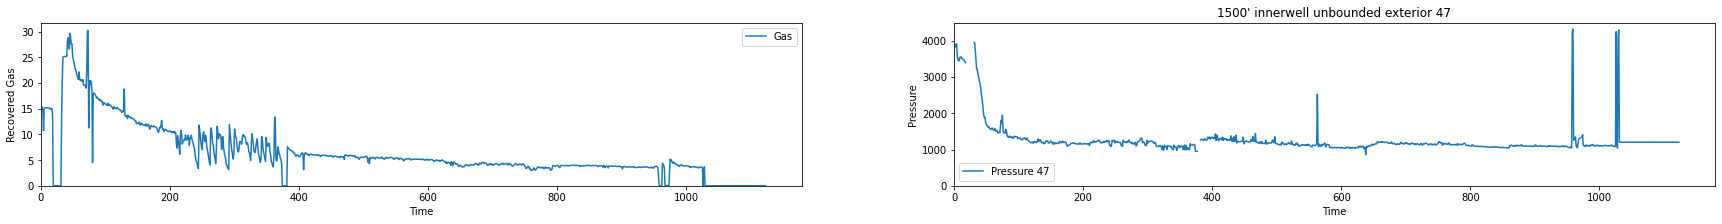

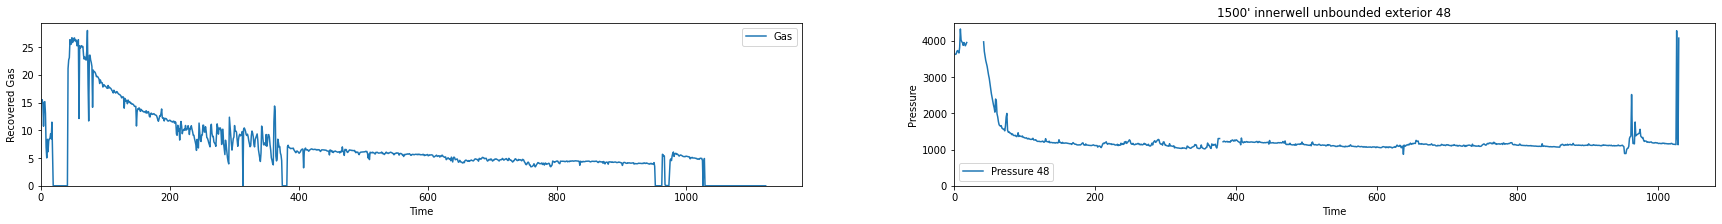

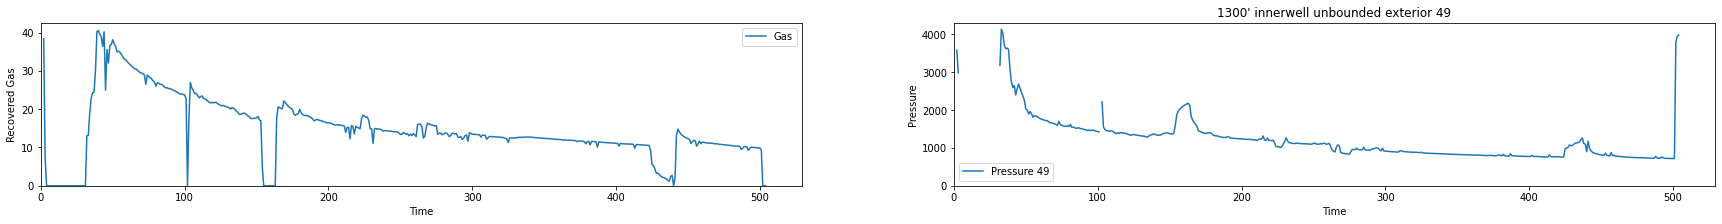

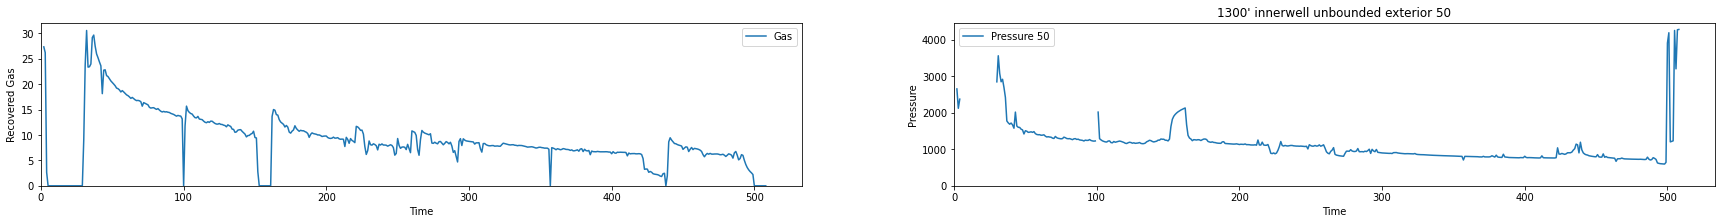

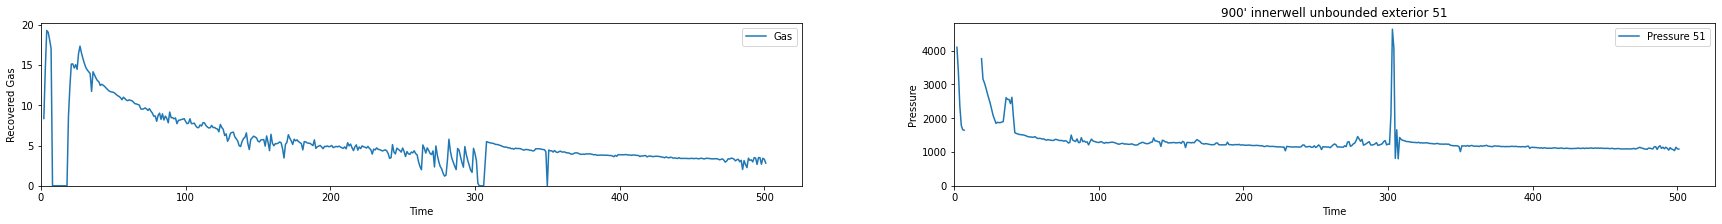

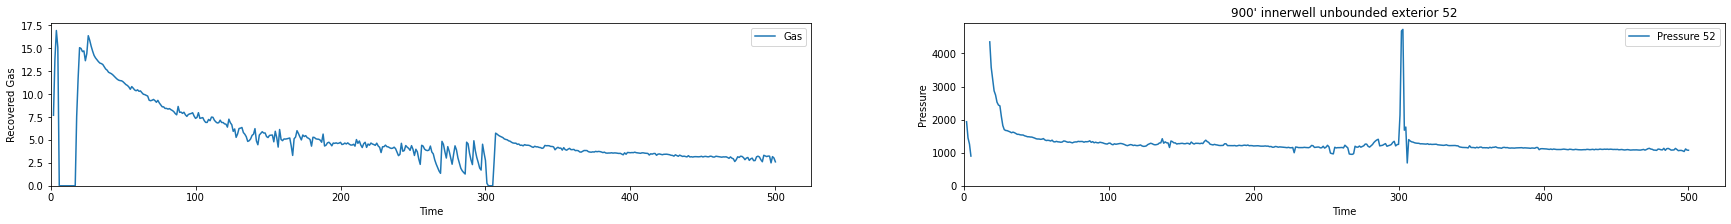

In [122]:
Type='Gas'
for WellNumber in range(1,53):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(30, 3)
    ax1.plot(D['Days'], D[Type], label=Type)
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered "+Type, ylim=(0,None), xscale='linear', xlim=(0,None))
    ax2.plot(D['Days'], D['Pressure'], label="Pressure "+str(WellNumber))
    ax2.legend()
    ax2.set(title=WellProperties.loc[WellNumber]["Comments"]+" "+str(WellNumber))
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='linear', xlim=(0,None))


In [123]:
WellProperties.loc[1]['DayMax']=1100
WellProperties.loc[1]['DayMax']=150

In [100]:
WellNumber=4
M0=100
M=200
tau=365*(M/M0)**2

Mlib[WellNumber]=M
Taulib[WellNumber]=tau

Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
#D=pd.read_excel(open(Filename,"rb"),engine="openpyxl",skiprows=[1,2],sheet_name="Production Data")
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E.set_index("Field")
Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

GoodDays = np.array(Data['Days'])
Days=np.arange(0,len(GoodDays))
time=np.arange(0,len(GoodDays))/tau
PressureTime=np.array(Data['Pressure'])
Gas=np.cumsum(np.array(Data['Gas']))
Pi=max(float(E.iloc[4][2]),max(PressureTime))
Pi=PressureTime[0]
Pf=PressureTime[0]
print("Initial pressure is",Pi)

pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)
flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)

print('mf=',flow_propertiesM.m_scaled_func(Pf))
res_realgasM = SinglePhaseReservoirMarder(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime=PressureTime)
rf2M = res_realgasM.recovery_factor()
rf2M[-1]



mf=flow_propertiesM.m_scaled_func(Pf)#Doesn't matter when pressure is varying
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Devation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gasM, label="Resource left")
ax.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax.plot(time, Gas/M, label="Gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


fig, ax = plt.subplots()
ax.plot(time, PressureTime, label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


Initial pressure is 5234.67495591206
mf= 0.448033721055063
CPU times: user 1.17 s, sys: 12.6 ms, total: 1.19 s
Wall time: 1.19 s
1.558388040799884


ValueError: A value in x_new is above the interpolation range.

In [3]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")
ms=2*cumtrapz(pvt_gas.P/(pvt_gas.Viscosity*pvt_gas["Z-Factor"]),pvt_gas.P)
ms=np.concatenate(([0],ms))
pvt_gas.pseudopressure=ms
#pvt_gas.Cg=1./pvt_gas.P-1/pvt_gas["Z-Factor"]*Zfunc.derivative()(pvt_gas.P)

M0=10
MMax=100000

In [ ]:
WellNumber=1
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
InitialPressure=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])
ReservoirTemperature_R_=float(E.loc['Reservoir Temperature (deg F)'][E.columns[0]])+459.67 
GasGravity=float(E.loc['Gas Specific Gravity'][E.columns[0]])

Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

GoodDays = np.array(Data['Days'])
Days=np.arange(0,len(GoodDays))
PressureTime=np.array(Data['Pressure'])
#
Nave=30
PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
#
Gas=np.cumsum(np.array(Data['Gas']))

if (WellNumber<12): #the low numbers are oil wells
    Pi=PressureTime[0]
else:
    Pi=max(float(E.iloc[4][2]),max(PressureTime))
Pf=Pi

if (WellNumber in Results.keys()):
    params=Results[WellNumber].params
    NTimes=50
else:
    params=Parameters()
    params.add('tau',value=1000.0,min=30.0,max=Days[-1]*2) #Days
    params.add('M',value=Gas[-1],min=Gas[-2],max=MMax) #MMcf
    params.add('Pi',value=Pi,min=max(PressureTime),max=12000) #MMcf
    NTimes=200
mini=Minimizer(obfun,params,fcn_args=(Days,Gas,pvt_gas,PressureTime))
result=mini.minimize(method='Nelder',max_nfev=NTimes)
print('Finished Nelder minimization with tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(result.params['tau'].value,result.params['Pi'].value,result.params['M'].value))
#result=mini.minimize(method='leastsq',xtol=1.e-4,params=result.params)
#print('Finished lstsqr minimization with tau={:5.2g} and M={:5.2g}'.format(result.params['tau'].value,result.params['M'].value))
print(' ##### {:} #####'.format(WellNumber))
Results[WellNumber]=result

# Find Many M-tau values

In [10]:
M0=10
MMax=100000
from FitFunctions import obfun

for WellNumber in range(20,27):
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))

    if (WellNumber<12): #the low numbers are oil wells
        Pi=PressureTime[0]
    else:
        Pi=max(float(E.iloc[4][2]),max(PressureTime))
    Pf=Pi

    if (WellNumber in Results.keys()):
        params=Results[WellNumber].params
        params['Pi'].set(max=14000)
        NTimes=200
    else:
        params=Parameters()
        params.add('tau',value=1000.0,min=30.0,max=Days[-1]*2) #Days
        params.add('M',value=Gas[-1],min=Gas[-2],max=MMax) #MMcf
        params.add('Pi',value=Pi,min=max(PressureTime),max=14000) #MMcf
        NTimes=100
    mini=Minimizer(obfun,params,fcn_args=(Days,Gas,pvt_gas,PressureTime))
    result=mini.minimize(method='Nelder',max_nfev=NTimes)
    print('Finished Nelder minimization with tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(result.params['tau'].value,result.params['Pi'].value,result.params['M'].value))
    #result=mini.minimize(method='leastsq',xtol=1.e-4,params=result.params)
    #print('Finished lstsqr minimization with tau={:5.2g} and M={:5.2g}'.format(result.params['tau'].value,result.params['M'].value))
    print(' ##### {:} #####'.format(WellNumber))
    Results[WellNumber]=result

Simulation took   1.1 s; tau is  138.48, Pi is   11004 and M is   37813
Simulation took     1 s; tau is  127.52, Pi is   11004 and M is   37813
Simulation took   1.2 s; tau is  138.48, Pi is   11004 and M is   37216
Simulation took   1.1 s; tau is  138.48, Pi is   10970 and M is   37813
Simulation took   1.1 s; tau is  131.12, Pi is   10981 and M is   38411
Simulation took   1.1 s; tau is  127.52, Pi is   10970 and M is   39011
Simulation took   1.1 s; tau is  123.97, Pi is   11015 and M is   38611
Simulation took   1.2 s; tau is  114.81, Pi is   10989 and M is   39144
Simulation took   1.2 s; tau is  116.68, Pi is   10979 and M is   40037
Simulation took   1.2 s; tau is  119.34, Pi is   10985 and M is   39479
Simulation took   1.2 s; tau is  132.73, Pi is   10991 and M is   38922
Simulation took   1.2 s; tau is  119.15, Pi is   10989 and M is   39089
Simulation took   1.1 s; tau is  127.78, Pi is   10998 and M is   38330
Simulation took   1.2 s; tau is  121.42, Pi is   10988 and M is 

Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.1 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is   39129
Simulation took   1.2 s; tau is  124.23, Pi is   10980 and M is 

Simulation took   2.6 s; tau is  110.91, Pi is   12000 and M is   21615
Simulation took   2.5 s; tau is  112.53, Pi is   12000 and M is   21637
Simulation took   2.5 s; tau is  110.45, Pi is   12000 and M is   21540
Simulation took   2.5 s; tau is  114.41, Pi is   12000 and M is   21677
Simulation took   2.5 s; tau is  116.77, Pi is   12000 and M is   21695
Simulation took   2.3 s; tau is  118.52, Pi is   12000 and M is   21707
Simulation took   2.5 s; tau is  114.01, Pi is   12000 and M is   21655
Simulation took   2.4 s; tau is  114.81, Pi is   12000 and M is   21706
Simulation took   2.5 s; tau is  115.19, Pi is   12000 and M is   21660
Simulation took   2.4 s; tau is  112.32, Pi is   12000 and M is   21633
Simulation took   2.5 s; tau is  111.99, Pi is   12000 and M is   21650
Simulation took   2.3 s; tau is  114.38, Pi is   12000 and M is   21657
Simulation took   2.3 s; tau is  116.23, Pi is   12000 and M is   21693
Simulation took   2.2 s; tau is  115.33, Pi is   12000 and M is 

Simulation took   2.4 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.5 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.2 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.2 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.4 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.7 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.2 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.4 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.3 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.3 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.3 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.6 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.5 s; tau is  115.12, Pi is   12000 and M is   21674
Simulation took   2.4 s; tau is  115.12, Pi is   12000 and M is 

Simulation took   2.6 s; tau is  286.48, Pi is   12263 and M is   17505
Simulation took   2.7 s; tau is  294.25, Pi is   12328 and M is   17582
Simulation took   2.6 s; tau is  270.25, Pi is   12223 and M is   17529
Simulation took   2.7 s; tau is  259.36, Pi is   12226 and M is   17604
Simulation took   2.6 s; tau is  279.58, Pi is   12254 and M is   17530
Simulation took   2.6 s; tau is  281.52, Pi is   12287 and M is   17581
Simulation took   2.8 s; tau is  287.25, Pi is   12318 and M is   17607
Simulation took   2.6 s; tau is  273.44, Pi is   12278 and M is   17614
Simulation took   2.6 s; tau is   270.4, Pi is   12290 and M is   17656
Simulation took   2.8 s; tau is  272.46, Pi is   12314 and M is   17619
Simulation took   2.6 s; tau is  275.47, Pi is   12263 and M is   17588
Simulation took   2.7 s; tau is  273.46, Pi is   12297 and M is   17609
Simulation took   2.6 s; tau is  274.97, Pi is   12272 and M is   17593
Simulation took   2.7 s; tau is  279.71, Pi is   12301 and M is 

Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.4 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.5 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.5 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.5 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.3 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.4 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.4 s; tau is   275.9, Pi is   12290 and M is   17627
Simulation took   2.4 s; tau is   275.9, Pi is   12290 and M is 

Simulation took   2.3 s; tau is  85.464, Pi is   12280 and M is   21817
Simulation took   2.3 s; tau is  85.892, Pi is   12289 and M is   21767
Simulation took   2.4 s; tau is   85.74, Pi is   12295 and M is   21750
Simulation took   2.3 s; tau is  85.533, Pi is   12284 and M is   21800
Simulation took   2.3 s; tau is  90.872, Pi is   12290 and M is   21913
Simulation took   2.3 s; tau is  84.555, Pi is   12286 and M is   21763
Simulation took   2.3 s; tau is  87.059, Pi is   12292 and M is   21800
Simulation took   2.3 s; tau is  85.912, Pi is   12286 and M is   21800
Simulation took   2.4 s; tau is  88.989, Pi is   12290 and M is   21862
Simulation took   2.4 s; tau is  85.648, Pi is   12287 and M is   21787
Simulation took   2.4 s; tau is  87.417, Pi is   12291 and M is   21816
Simulation took   2.3 s; tau is  86.287, Pi is   12287 and M is   21804
Simulation took   2.4 s; tau is  87.704, Pi is   12286 and M is   21874
Simulation took   2.3 s; tau is  88.255, Pi is   12287 and M is 

Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.8 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.9 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Simulation took   2.7 s; tau is  88.118, Pi is   12290 and M is   21859
Finished Nelder minimization with tau= 88.118, Pi=  12290 and M=   21859
 ##### 23 #####
Simulation took   1.2 s; tau is    1000, Pi is   10450 and M is   10873
Simulation took   1.3 s; tau is    1007, Pi is   10450 and M is   10873
Simulation took   1.3 s; tau is    1000, Pi is   10450 and M is   10966
Simulation took   1.2 s; tau is    1000, Pi is 

Simulation took  0.66 s; tau is    1000, Pi is   10800 and M is  7631.5
Simulation took  0.65 s; tau is    1000, Pi is   10750 and M is  7550.7
Simulation took  0.64 s; tau is  1003.1, Pi is   10851 and M is  7573.5
Simulation took  0.65 s; tau is  996.63, Pi is   10834 and M is  7657.7
Simulation took  0.64 s; tau is  990.68, Pi is   10851 and M is  7840.2
Simulation took  0.65 s; tau is  997.37, Pi is   10868 and M is  8108.3
Simulation took  0.64 s; tau is  995.87, Pi is   10903 and M is  8899.2
Simulation took  0.66 s; tau is  984.44, Pi is   10851 and M is  8899.2
Simulation took  0.64 s; tau is  968.87, Pi is   10851 and M is   10289
Simulation took  0.68 s; tau is  965.88, Pi is   10938 and M is   11316
Simulation took  0.69 s; tau is  938.06, Pi is   11009 and M is   15091
Simulation took  0.66 s; tau is  945.66, Pi is   10991 and M is   17419
Simulation took  0.67 s; tau is  912.82, Pi is   11063 and M is   26589
Simulation took  0.68 s; tau is  846.45, Pi is   11045 and M is 

Simulation took   0.7 s; tau is  909.95, Pi is   11248 and M is   27365
Simulation took  0.72 s; tau is  843.53, Pi is   11231 and M is   29645
Simulation took  0.75 s; tau is  717.01, Pi is   11300 and M is   45671
Simulation took  0.75 s; tau is  717.01, Pi is   11460 and M is   55088
Simulation took  0.79 s; tau is  594.21, Pi is   11478 and M is   74487
Simulation took  0.69 s; tau is  870.78, Pi is   11265 and M is   27365
Simulation took  0.67 s; tau is  934.12, Pi is   11091 and M is   16233
Simulation took  0.73 s; tau is   781.3, Pi is   11365 and M is   43743
Simulation took  0.77 s; tau is   646.7, Pi is   11373 and M is   51014
Simulation took   0.7 s; tau is   856.2, Pi is   11279 and M is   32764
Simulation took  0.75 s; tau is  691.13, Pi is   11364 and M is   55264
Simulation took  0.72 s; tau is  831.06, Pi is   11290 and M is   33708
Simulation took   0.7 s; tau is  910.76, Pi is   11322 and M is   28336
Simulation took  0.73 s; tau is   772.5, Pi is   11306 and M is 

CPU times: user 1.1 s, sys: 3.06 ms, total: 1.11 s
Wall time: 1.11 s
tau= 124.23, Pi=  10980 and M=   39129
CPU times: user 2.51 s, sys: 11.8 ms, total: 2.52 s
Wall time: 2.52 s
tau= 115.12, Pi=  12000 and M=   21674
CPU times: user 2.56 s, sys: 9.03 ms, total: 2.56 s
Wall time: 2.57 s
tau=  275.9, Pi=  12290 and M=   17627
CPU times: user 2.34 s, sys: 7.25 ms, total: 2.35 s
Wall time: 2.35 s
tau= 88.118, Pi=  12290 and M=   21859
CPU times: user 1.04 s, sys: 4.1 ms, total: 1.05 s
Wall time: 1.05 s
tau= 966.33, Pi=  11563 and M=   35491
CPU times: user 660 ms, sys: 1.36 ms, total: 661 ms
Wall time: 662 ms
tau=  897.4, Pi=  12286 and M=   32271
CPU times: user 666 ms, sys: 1.7 ms, total: 667 ms
Wall time: 668 ms
tau= 999.04, Pi=  12018 and M=   42042


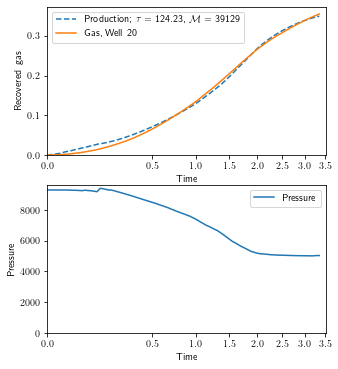

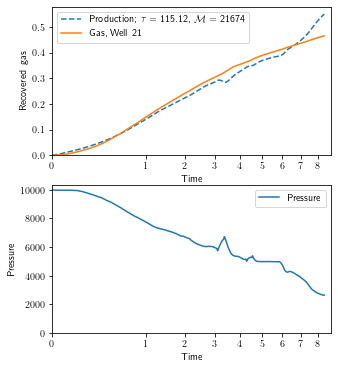

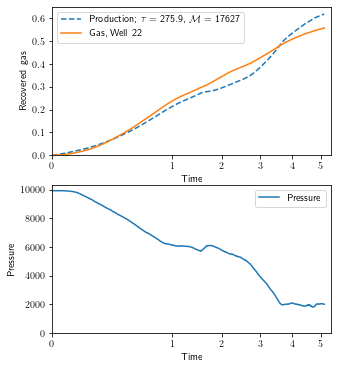

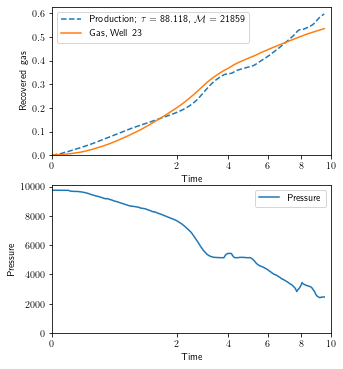

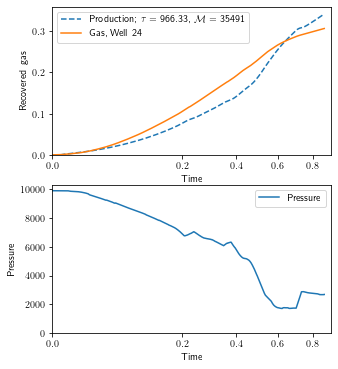

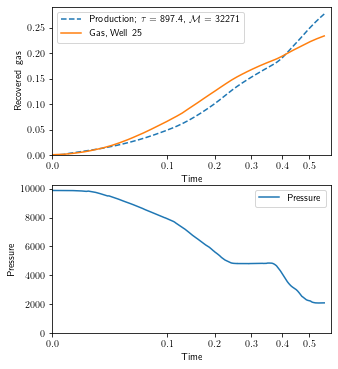

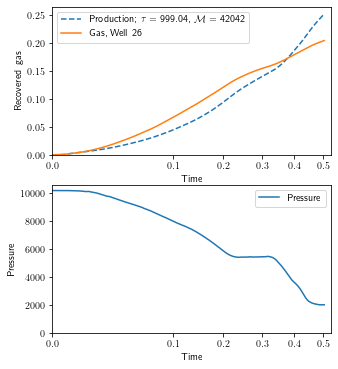

In [11]:
plt.rcParams['text.usetex'] = True
for WellNumber in range(20,27):#Results.keys():
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    Filename2="../../PressureData/SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
    E=pd.read_csv(open(Filename2,"r"))
    E.set_index("Field")
    Data=D[(D['Gas']>0) & (pd.notna(D['Pressure']))][['Days','Gas','Pressure']]

    GoodDays = np.array(Data['Days'])
    Days=np.arange(0,len(GoodDays))
    PressureTime=np.array(Data['Pressure'])
    #
    Nave=30
    PressureTime=sp.ndimage.filters.uniform_filter1d(PressureTime, size=Nave)
    #
    Gas=np.cumsum(np.array(Data['Gas']))
    M=Results[WellNumber].params['M'].value
    tau=Results[WellNumber].params['tau'].value
    Pi=Results[WellNumber].params['Pi'].value
    Pf=Pi

    flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
    res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)
    %time res_realgasM.simulate(Days/tau,PressureTime=PressureTime)
    print('tau={:7.5g}, Pi={:7.5g} and M={:8.5g}'.format(tau,Pi,M))
    rf2M = res_realgasM.recovery_factor()
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(5, 6)
    ax1.plot(Days/tau, rf2M,"--", label=r"Production; $\tau=${:7.5g}, $\mathcal M=${:7.5g}".format(tau,M))
    ax1.plot(Days/tau, Gas/M, label="Gas, Well "+str(WellNumber))
    ax1.legend()
    ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    ax2.plot(Days/tau, PressureTime, label="Pressure")
    ax2.legend()
    ax2.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))

    pp=PdfPages('Wells'+str(WellNumber)+'.pdf')
    pp.savefig(fig)
    pp.close()


In [37]:
Results[21].params['tau'].value=500

CPU times: user 1.75 s, sys: 64.9 ms, total: 1.81 s
Wall time: 1.81 s
tau is   242.57 and M is 1.76e+04


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Pressure'),
 (0.0, 10332.935043872363),
 None,
 (0.0, 6.129358634652561)]

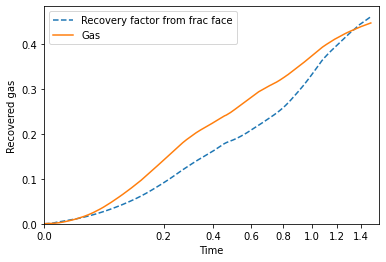

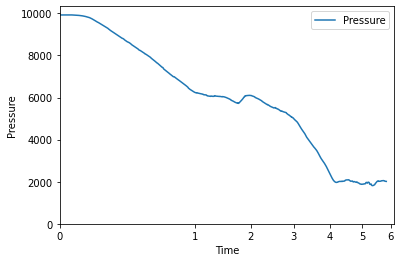

In [63]:
Pi=12000
Pf=Pi
M2=22000
tau2=950

flow_propertiesM = FlowPropertiesMarder(pvt_gas, Pi)
res_realgasM = SinglePhaseReservoirMarder(80, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(Days/tau2,PressureTime=PressureTime)
print("tau is {:8.6g} and M is {:5.3g}".format(tau,M))
rf2M = res_realgasM.recovery_factor()
fig, ax = plt.subplots()
ax.plot(Days/tau2, rf2M,"--", label="Recovery factor from frac face")
ax.plot(Days/tau2, Gas/M2, label="Gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))


fig, ax = plt.subplots()
ax.plot(Days/tau, PressureTime, label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Pressure'),
 (0.0, 8070.94802),
 None,
 (0.0, 437.8)]

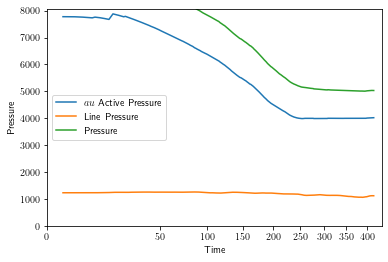

In [89]:
WellNumber=20
F= sp.ndimage.filters.uniform_filter1d 
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
#print(D)

fig, ax = plt.subplots()
ax.plot(D["Days"], F(D["Active Pressure"],size=30), label=r"$\tau$ Active Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel=r"\tau Active Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))


ax.plot(D["Days"], F(D["Line Pressure"],size=30), label="Line Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel=r"\tau", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax.plot(D["Days"], F(D["Pressure"],size=30), label="Pressure")
ax.legend()
ax.set(xlabel="Time", ylabel="Pressure", ylim=(0,None), xscale='squareroot', xlim=(0,None))



In [76]:

pkl.dump(Results,file=open("Results.pkl","wb"))

In [61]:
dir(time)

['CLOCK_MONOTONIC',
 'CLOCK_MONOTONIC_RAW',
 'CLOCK_PROCESS_CPUTIME_ID',
 'CLOCK_REALTIME',
 'CLOCK_THREAD_CPUTIME_ID',
 'CLOCK_UPTIME_RAW',
 '_STRUCT_TM_ITEMS',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'altzone',
 'asctime',
 'clock_getres',
 'clock_gettime',
 'clock_gettime_ns',
 'clock_settime',
 'clock_settime_ns',
 'ctime',
 'daylight',
 'get_clock_info',
 'gmtime',
 'localtime',
 'mktime',
 'monotonic',
 'monotonic_ns',
 'perf_counter',
 'perf_counter_ns',
 'process_time',
 'process_time_ns',
 'sleep',
 'strftime',
 'strptime',
 'struct_time',
 'thread_time',
 'thread_time_ns',
 'time',
 'time_ns',
 'timezone',
 'tzname',
 'tzset']